In [2]:
from sys import path
import numpy as np

path.append("..")

from src.data import EDADataset

In [3]:
data_paths: dict[str, str] = {
    "USILaughs": "../data.nosync/usilaughs/data_right.npz",
    "SEED": "../data.nosync/seed/data_engagement_10sec_35thresh.npz",
    "BiHeartS": "../data.nosync/bihearts/data_left.npz",
    "APSYNC": "../data.nosync/apsync/data_engagement_10sec.npz",
}

loaded_data: dict[str, dict[str, np.ndarray]] = {
    dataset_name: EDADataset._load_data(data_path)
    for dataset_name, data_path in data_paths.items()
}

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_stacked_label_distribution(
    loaded_data: dict[str, dict[str, np.ndarray]],
    title: str = "Label Distribution Across Datasets",
    figsize: tuple[float, float] = (7, 5),  # Golden ratio: 10 / 1.618 ≈ 6.18
    colors: list[str] = None,
    use_latex: bool = False,
):
    """
    Create a stacked bar chart showing binary label distributions across datasets with group subdivisions.
    
    Args:
        loaded_data: Dictionary with dataset names as keys and data dictionaries as values 
                    (containing 'labels' and 'groups' keys)
        title: Plot title
        figsize: Figure size
        colors: Colors for the two classes [class_0_color, class_1_color]
        use_latex: Whether to use LaTeX formatting
    """
    # Set LaTeX-compatible font settings
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman", "Times", "DejaVu Serif"],
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "font.size": 12,
    })
    
    if use_latex:
        plt.rcParams.update({
            "text.usetex": True,
        })
    
    # Set colorblind-friendly colors if not provided
    if colors is None:
        # Using colorblind-friendly palette: blue and orange
        colors = ['#1f77b4', '#ff7f0e']  # Blue and orange from matplotlib's default cycle
    
    # Calculate counts for each dataset
    datasets = list(loaded_data.keys())
    class_0_counts = []
    class_1_counts = []
    group_subdivisions = []  # Store group boundary info for each dataset
    
    for dataset_name in datasets:
        data_dict = loaded_data[dataset_name]
        labels = data_dict['labels']
        groups = data_dict['groups']
        
        # Calculate overall class counts
        unique_vals, counts = np.unique(labels, return_counts=True)
        count_dict = dict(zip(unique_vals, counts))
        class_0_counts.append(count_dict.get(0, 0))
        class_1_counts.append(count_dict.get(1, 0))
        
        # Calculate group subdivisions for each class
        unique_groups = np.unique(groups)
        group_info = {'class_0': [], 'class_1': []}
        
        for group in unique_groups:
            group_mask = groups == group
            group_labels = labels[group_mask]
            
            group_class_0 = np.sum(group_labels == 0)
            group_class_1 = np.sum(group_labels == 1)
            
            group_info['class_0'].append(group_class_0)
            group_info['class_1'].append(group_class_1)
        
        group_subdivisions.append(group_info)
    
    # Create the stacked bar chart
    plt.figure(figsize=figsize)
    
    x_pos = np.arange(len(datasets))
    
    # Create stacked bars
    bars1 = plt.bar(x_pos, class_0_counts, color=colors[0], label='Class 0', edgecolor='black', linewidth=0.5)
    bars2 = plt.bar(x_pos, class_1_counts, bottom=class_0_counts, color=colors[1], label='Class 1', edgecolor='black', linewidth=0.5)
    
    # Add group subdivision lines
    for i, (bar1, bar2, group_info) in enumerate(zip(bars1, bars2, group_subdivisions)):
        bar_x = bar1.get_x()
        bar_width = bar1.get_width()
        
        # Add subdivision lines for class 0
        cumulative_0 = 0
        for j, count in enumerate(group_info['class_0'][:-1]):  # Skip last line
            cumulative_0 += count
            if cumulative_0 > 0 and cumulative_0 < class_0_counts[i]:
                plt.plot([bar_x, bar_x + bar_width], [cumulative_0, cumulative_0], 
                        'k-', alpha=0, linewidth=1)
        
        # Add subdivision lines for class 1
        cumulative_1 = class_0_counts[i]  # Start from top of class 0
        for j, count in enumerate(group_info['class_1'][:-1]):  # Skip last line
            cumulative_1 += count
            if cumulative_1 > class_0_counts[i] and cumulative_1 < class_0_counts[i] + class_1_counts[i]:
                plt.plot([bar_x, bar_x + bar_width], [cumulative_1, cumulative_1], 
                        'k-', alpha=0, linewidth=1)
    
    # Customize the plot
    plt.xlabel('Dataset', fontweight='bold', fontsize=16)
    plt.ylabel('Count', fontweight='bold', fontsize=16)
    plt.title(title, fontweight='bold', pad=20, fontsize=18)
    plt.xticks(x_pos, datasets, rotation=45, ha='right', fontsize=14)
    plt.legend(loc='upper right', fontsize=14)
    
    # Add value annotations on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        total_count = class_0_counts[i] + class_1_counts[i]
        
        # Annotate class 0
        if class_0_counts[i] > 0:
            pct_0 = (class_0_counts[i] / total_count) * 100
            plt.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height()/2,
                    f'{class_0_counts[i]} ({pct_0:.1f}%)', ha='center', va='center', 
                    fontweight='black', fontsize=13)
        
        # Annotate class 1
        if class_1_counts[i] > 0:
            pct_1 = (class_1_counts[i] / total_count) * 100
            plt.text(bar2.get_x() + bar2.get_width()/2, 
                    class_0_counts[i] + bar2.get_height()/2,
                    f'{class_1_counts[i]} ({pct_1:.1f}%)', ha='center', va='center', 
                    fontweight='black', fontsize=13)
    
    plt.grid(axis='y', alpha=0, linestyle='--')
    plt.tight_layout()
    plt.savefig("../figures/data_distribution.pdf", bbox_inches='tight')
    plt.show()

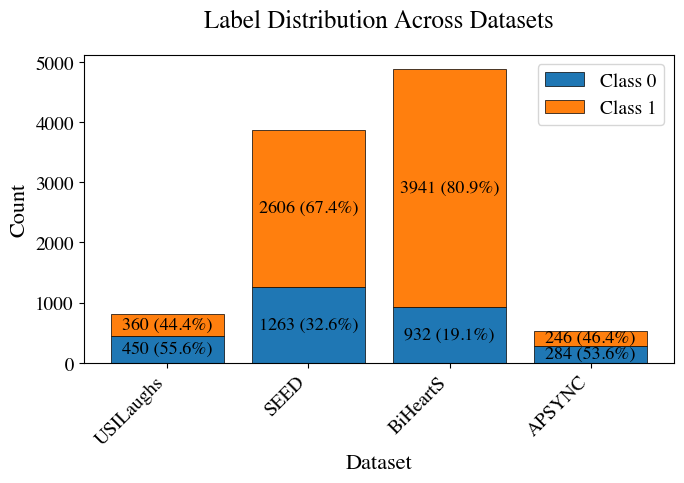

In [6]:
# Test the function
plot_stacked_label_distribution(loaded_data)

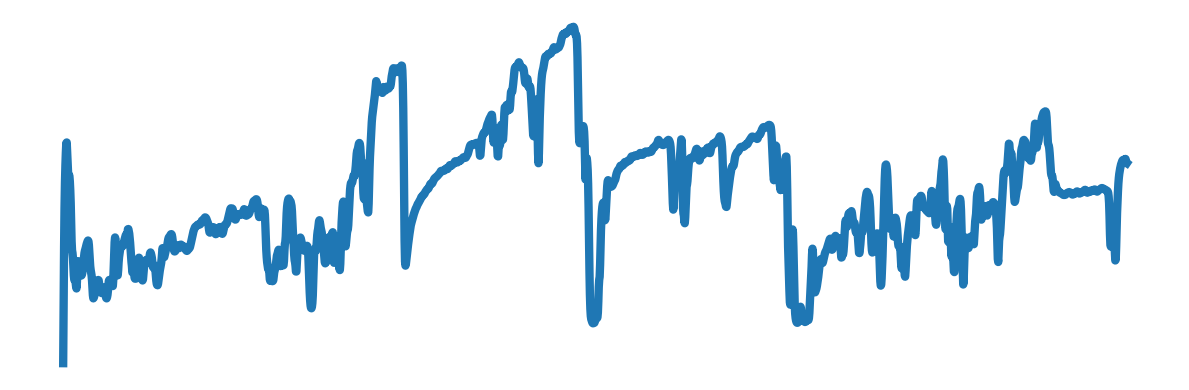

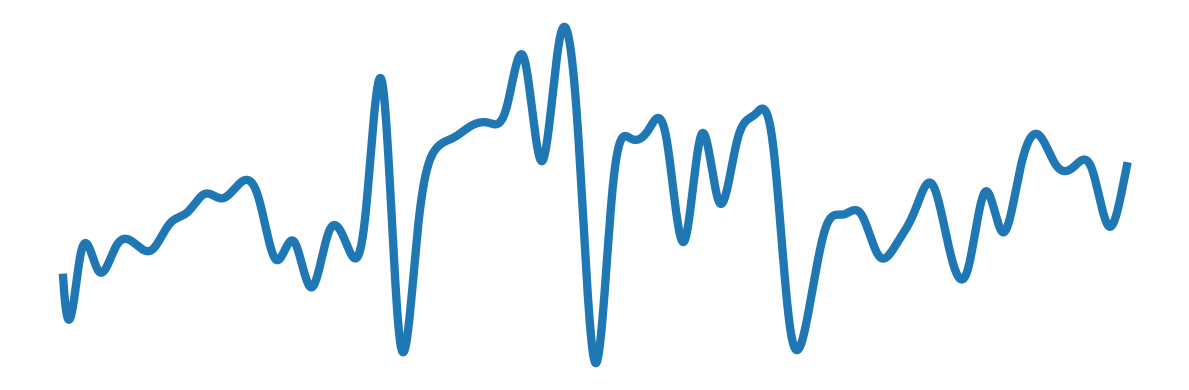

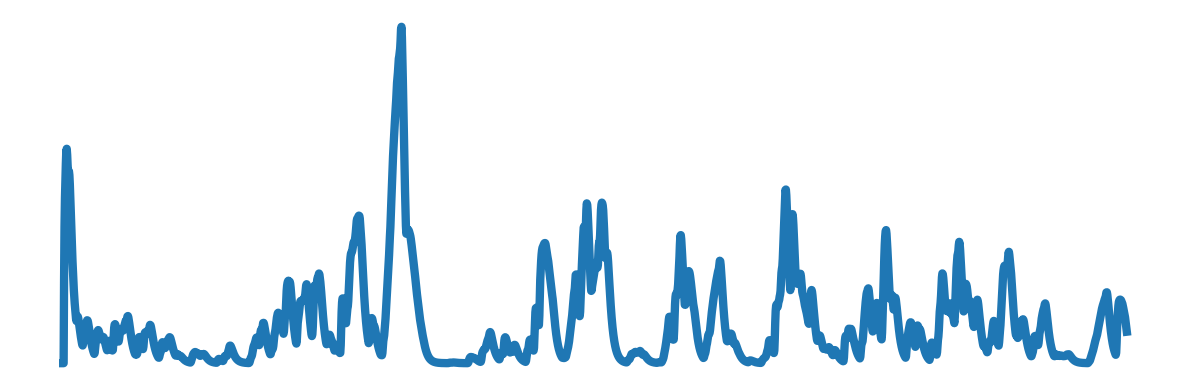

Signal shape: (2400, 3)
Signal duration: 600.0 seconds
Label: 0 (Negative)
Group: U13


In [28]:
# Plot a random signal from USILaughs dataset
import matplotlib.pyplot as plt
import numpy as np

# Get USILaughs data
usi_data = loaded_data["BiHeartS"]
signals = usi_data["values"]
labels = usi_data["labels"]
groups = usi_data["groups"]

# Select a random signal
random_idx = np.random.randint(0, len(signals))
random_signal = signals[random_idx]
random_label = labels[random_idx]
random_group = groups[random_idx]

# Set up the plot with LaTeX-compatible fonts
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "Times", "DejaVu Serif"],
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "font.size": 10,
})

# Create the plot - clean version for export


for i, name in zip(range(random_signal.shape[1]), ["mixed", "tonic", "phasic"]):
    plt.figure(figsize=(12, 4))
    time_axis = np.arange(len(random_signal)) / 4  # Assuming 1000 Hz sampling rate, convert to seconds
    plt.plot(time_axis, random_signal[:,i], linewidth=6, color='#1f77b4')
    # Remove all background elements for clean export
    plt.axis('off')  # Remove all axes, labels, and ticks
    plt.tight_layout()

    # Save the clean plot
    plt.savefig(f"../figures/random_signal_clean_{name}.svg", bbox_inches='tight', 
                transparent=True, dpi=300, pad_inches=0)
    plt.show()
    plt.close()


print(f"Signal shape: {random_signal.shape}")
print(f"Signal duration: {len(random_signal) / 4:.1f} seconds")
print(f"Label: {random_label} ({'Positive' if random_label == 1 else 'Negative'})")
print(f"Group: {random_group}")